## Advanced DL and RL: Домашнее задание 1

Студент: **Панфилов Александр**

Группа: **MADE-DS-32**

### Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. 

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

1. численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
2. туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
3. игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
4. игрок может совершать одно из двух действий:
     1. hit  — взять ещё одну карту;
     2. stand — не брать больше карт;

5. если сумма очков у игрока на руках больше 21, он проигрывает (bust);
6. если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17; после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
7. в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).

#### Пункт 1
Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

#### Пункт 2
Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

#### Пункт 3
Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [1]:
import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
import itertools

import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make('Blackjack-v0')
env.natural = True

In [3]:
print("Action space:", env.action_space.n, "Hit or Stand")
actionSpace = list(range(env.action_space.n))

# т.к. на руках может быть не меньше 2 (2 туза) и при sum > 21 игра заканчивается
state_player_sums = list(range(4, 22))

# открытая дилером карта
state_dealer_cards = list(range(1, env.observation_space[1].n))

state_usable_ace = [False, True]

Action space: 2 Hit or Stand


In [4]:
def make_pi_policy_greedy_action(Q, pi_policy, state, actionSpace):
    """
    Выбираем действие по эпсилон жадной стратегии и обновляем pi стратегию
    
    """
    values = np.array([Q[key] for key in Q.keys() if state in key ])

    
#   argmax для равновероятных действий
    best = np.random.choice(np.where(values==values.max())[0]) 
    
    pi_policy[state] = actionSpace[best]
    
    return pi_policy[state]

def make_b_policy_soft_action(b_policy, pi_policy, state, actionSpace, eps=0.1):
    """
    Выбираем действие по эпсилон мягкой стратегии и обновляем b стратегию
    
    """
    rand = np.random.random()
    #   
    if rand < 1 - eps:
        b_policy[state] = [pi_policy[state]]
    else:
        b_policy[state] = actionSpace
    
    return np.random.choice(b_policy[state])

In [5]:
def run_episode(pi_policy, env, actionSpace, eps=0.1):
    state = env.reset()
    b_policy = {}
    ended = False
    
    actions = []
    states = [state]
    rewards = []
        
    while not ended:
        action = make_b_policy_soft_action(b_policy, pi_policy, state, actionSpace, eps=eps)
        state, reward, ended, info = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        states.append(state)
    else:
        states.pop()
        
    return b_policy, states, actions, rewards

In [6]:
def conduct_experiments_pi(pi_policy, env, num_experiments=1000, return_states=False):
    total_reward = []
    wins = 0
    draws = 0
    losses = 0
    
    if return_states:
        states = []
        rewards = [0]
        num_experiments = 1
        
    for _ in range(num_experiments):
        state = env.reset()
        if return_states:
            states.append((state, pi_policy[state]))

        total_reward.append(0)
        ended = False
        while not ended:
            action = pi_policy[state]
            state, reward, ended, info = env.step(action)
            total_reward[-1] += reward
            if return_states and state[0] < 22:
                rewards.append(reward)
                states.append((state, pi_policy[state]))

        else:   
            if reward >= 1:
                wins += 1
            elif reward == 0:
                draws += 1
            else:
                losses += 1

    env.close()
    if return_states:
        return states, rewards
    
    return np.mean(total_reward), wins / num_experiments, losses / num_experiments, draws / num_experiments

In [7]:
def plot_rewards(indicies, results, eps=0.1):
    plt.figure(figsize=(12, 8))
    plt.plot(indicies, results, linewidth=1.5)
    plt.xlim(left=1)
    plt.xlabel("Количество сыгранных эпизодов")
    plt.ylabel("Средний выигрыш")
    plt.title(f"Средние выигрыши после эпизода {i}, текущий epsilon {eps:.4f}")
    plt.xlim(left=1)
    plt.minorticks_on()

    plt.grid(True)
    
def plot_stats(indicies, wins, loses, draws, eps=0.1):
    plt.figure(figsize=(12, 8))
    plt.plot(indicies, wins, label="Процент побед", linewidth=1.5)
    plt.plot(indicies, loses, label="Процент поражений", linewidth=1.5)
    plt.plot(indicies, draws, label="Процент ничьих", linewidth=1.5)
    plt.xlim(left=1)
    plt.xlabel("Количество сыгранных эпизодов")
    plt.ylabel("%")
    plt.title(f"Средние после эпизода {i}, текущий epsilon {eps:.4f}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# INIT PART

#  all posible states
S = list(itertools.product(state_player_sums, state_dealer_cards, state_usable_ace))

# for task one
Q_truncated = dict()
returns_truncated = []
pi_policy_truncated = {}

for state in S:
    if state[0] > 18:
        Q_truncated[state, 1] = 0
        pi_policy_truncated[state] = 1
    else:
        Q_truncated[state, 0] = 0
        pi_policy_truncated[state] = 0

# action-value function (state, action)
Q = dict()
for state in S:
    Q[state, 0] = 0
    Q[state, 1] = 0
    
# знаменатель в weighted importance sampling C (s.t, a.t)
C = dict()
for state in S:
    C[state, 0] = 0
    C[state, 1] = 0

# гиперпараметры
epsilon = 0.3
eps_decay = 3e-7
gamma = 1

pi_policy = {}
for state in S:
    make_pi_policy_greedy_action(Q, pi_policy, state, actionSpace=actionSpace)

In [9]:
def update_returns(R, states, rewards, R_all=None):
    state_first_visit = {state: -1 for state in states}
    
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        
        if state_first_visit[states[t]] == t:
            R[states[t]].append(g)
            
            if R_all is not None:
                R_all[states[t]].append(g)
                
    for state in states:
        if state_first_visit[state] == -1:
            R_all[state].append(np.nan)
            
    return R, R_all

R, R_all = {state: [] for state in Q_truncated}, {state: [] for state in Q_truncated}

for _ in range(100000):
    states, rewards = conduct_experiments_pi(pi_policy_truncated, env, return_states=True)
    R, R_all = update_returns(R, states, rewards, R_all=R_all)

for state in Q_truncated:
    if len(R[state]) > 0:
        Q_truncated[state] = np.mean(R[state])

In [10]:
# Честно говоря, не до конца понял, что нужно делать в пунте 1, вроде это то, что нужно

np.mean(list(Q_truncated.values()))

-0.21695077611795288

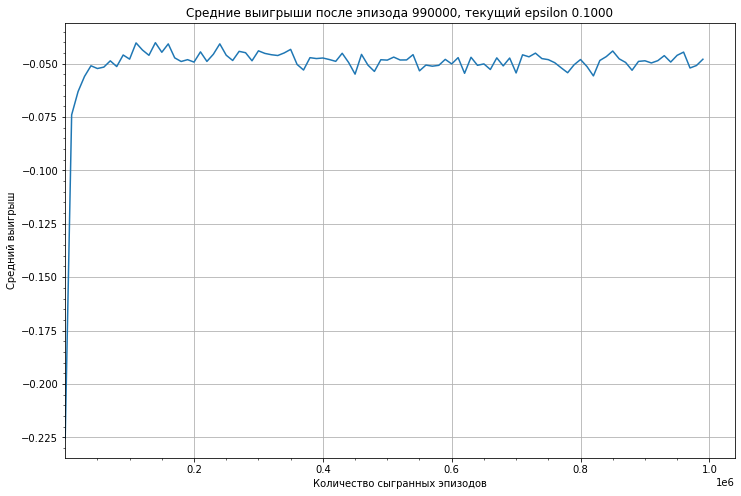

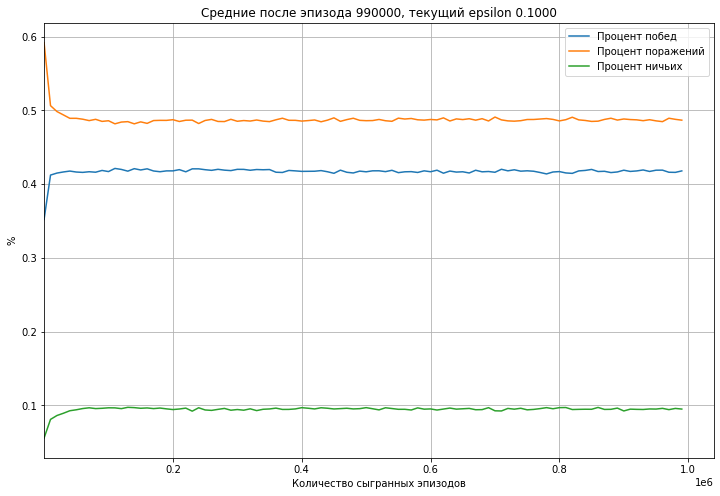

In [11]:
training_episodes = 1_000_000

experiments_mean = []
wins_mean = []
loses_mean = []
draws_mean = []

indicies = []

for i in range(training_episodes):        
    if i % 1_000_0 == 0:
        indicies.append(i)
        
        mean_rewards, mean_wins, mean_loses, mean_draws = conduct_experiments_pi(pi_policy, env, 1_000_00)
        experiments_mean.append(mean_rewards)
        wins_mean.append(mean_wins)
        loses_mean.append(mean_loses)
        draws_mean.append(mean_draws)

        plot_rewards(indicies, experiments_mean, eps=epsilon)
        plot_stats(indicies, wins_mean, loses_mean, draws_mean, eps=epsilon)
        clear_output(wait=True)
    
#     MC off-policy algorithm
    b_policy, states, actions, rewards = run_episode(pi_policy, env, actionSpace, epsilon)
    
    G = 0
    W = 1
  
    for state, action, reward in reversed(list(zip(states, actions, rewards))): 
        G = gamma*G + reward
        C[state, action] += W
        Q[state, action] += (W / C[state, action])*(G-Q[state, action])                
        pi_policy_action = make_pi_policy_greedy_action(Q, pi_policy, state, actionSpace=actionSpace)

        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if action != pi_policy_action:
            break

        soft_prob_b = 0
        if len(b_policy[state]) == 1:
            soft_prob_b = 1 - epsilon 
        soft_prob_b += epsilon / len(b_policy[state])        

        W *= 1 / soft_prob_b                         
#         пробуем уменьшать exploration
        if epsilon > 0.1:
            epsilon -= eps_decay

### Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. 

Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. 

Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
> *double* — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается. 

#### Пункт 4
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

#### Пункт 5
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [12]:
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
#         Добавили третье действие
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward > 0:
                reward = 1.5
        elif action == 2:  # double: draw a card and call for a dealer with a doubled reward
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward > 0:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [13]:
env_custom_blackjack = BlackjackEnv(True)

In [14]:
# INIT PART 2

# action-value function (state, action)
Q_custom = dict()
for state in S:
    Q_custom[state, 0] = 0
    Q_custom[state, 1] = 0
    Q_custom[state, 2] = 0

    
# знаменатель в weighted importance sampling C (s.t, a.t)
C_custom = dict()
for state in S:
    C_custom[state, 0] = 0
    C_custom[state, 1] = 0
    C_custom[state, 2] = 0


# гиперпараметры
epsilon = 0.3
eps_decay = 2e-7
gamma = 0.6

pi_policy_double = {}
for state in S:
    make_pi_policy_greedy_action(Q_custom, pi_policy_double, state, [0, 1, 2])

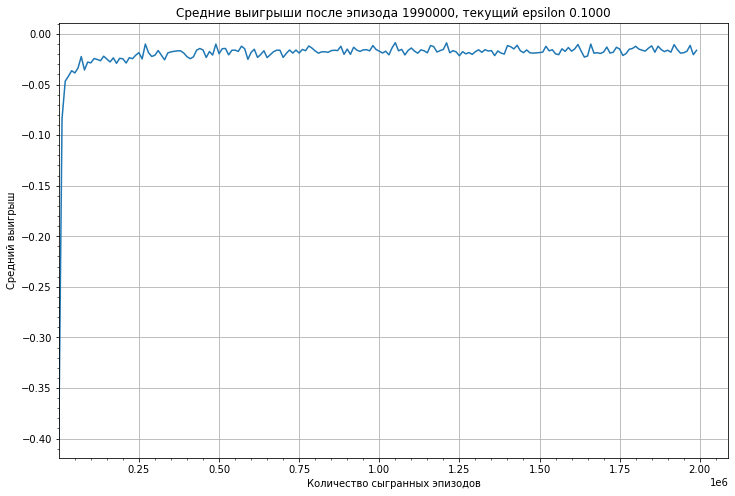

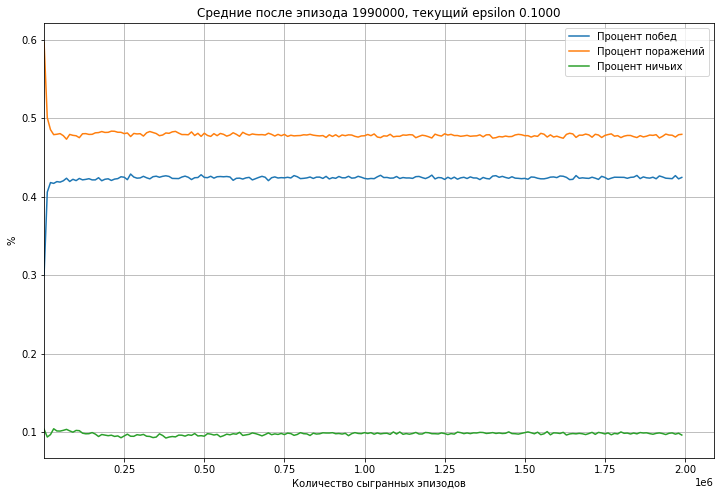

In [15]:
training_episodes = 2_000_000

experiments_mean = []
wins_mean = []
loses_mean = []
draws_mean = []

indicies = []

for i in range(training_episodes):        
    if i % 1_000_0 == 0:
        indicies.append(i)
        
        mean_rewards, mean_wins, mean_loses, mean_draws = conduct_experiments_pi(pi_policy_double, env_custom_blackjack, 1_000_00)
        experiments_mean.append(mean_rewards)
        wins_mean.append(mean_wins)
        loses_mean.append(mean_loses)
        draws_mean.append(mean_draws)

        plot_rewards(indicies, experiments_mean, eps=epsilon)
        plot_stats(indicies, wins_mean, loses_mean, draws_mean, eps=epsilon)
        clear_output(wait=True)
    
#     MC off-policy algorithm
    b_policy, states, actions, rewards = run_episode(pi_policy_double, env_custom_blackjack, [0, 1, 2], epsilon)
    
    G = 0
    W = 1
    
    for state, action, reward in reversed(list(zip(states, actions, rewards))): 
        G = gamma*G + reward

        C_custom[state, action] += W
        Q_custom[state, action] += (W / C_custom[state, action])*(G-Q_custom[state, action])                
        pi_policy_action = make_pi_policy_greedy_action(Q_custom, pi_policy_double, state, [0, 1, 2])

        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if action != pi_policy_action:
            break

        soft_prob_b = 0
        if len(b_policy[state]) == 1:
            soft_prob_b = 1 - epsilon 
        soft_prob_b += epsilon / len(b_policy[state])        

        W *= 1 / soft_prob_b                         
#         пробуем уменьшать exploration
        if epsilon > 0.1:
            epsilon -= eps_decay

### Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. 

После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.
Думаю, у вас уже возникла в голове эта картинка:
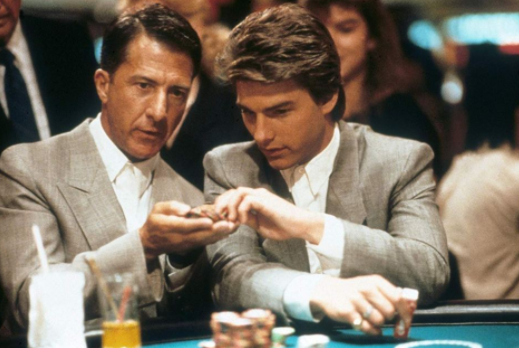

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

#### Пункт 6
Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

#### Пункт 7
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [52]:
"""
В качестве решения, я решил попробовать добавить в observation текущее количество карт в колоде.
Одна и та же олода из 32 карт используется при нескольких эпизодах, пока на начало какого-то из эпизодов 
в ней не окажется менее 15 карт.

"""
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


class BlackjackEnvCardsAmount(gym.Env):
    def __init__(self, natural=False):
#         Добавили третье действие
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.const_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.cards_amnt = 32
        self.deck = self.const_deck*4

        # Start the first game
        self.reset()
        

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward > 0:
                reward = 1.5
        elif action == 2:  # double: draw a card and call for a dealer with a doubled reward
            self.player.append(self.draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward > 0:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.cards_amnt)

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        
        if self.cards_amnt <= 15:
            self.deck = self.const_deck*4
            self.cards_amnt = 32
        self.cards_amnt -= 4
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)

        return card
    
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

In [53]:
env_final = BlackjackEnvCardsAmount(True)

In [59]:
# INIT PART 3
state_cards_amount = list(range(8, 29))
#  all posible states
S_final = list(itertools.product(state_player_sums, state_dealer_cards, state_usable_ace, state_cards_amount))

# action-value function (state, action)
Q_final = dict()
for state in S_final:
    Q_final[state, 0] = 0
    Q_final[state, 1] = 0
    Q_final[state, 2] = 0

    
# знаменатель в weighted importance sampling C (s.t, a.t)
C_final = dict()
for state in S_final:
    C_final[state, 0] = 0
    C_final[state, 1] = 0
    C_final[state, 2] = 0


# гиперпараметры
epsilon = 0.5
eps_decay = 3e-7
gamma = 0.2

pi_policy_final = {}
for state in S_final:
    make_pi_policy_greedy_action(Q_final, pi_policy_final, state, [0, 1, 2])

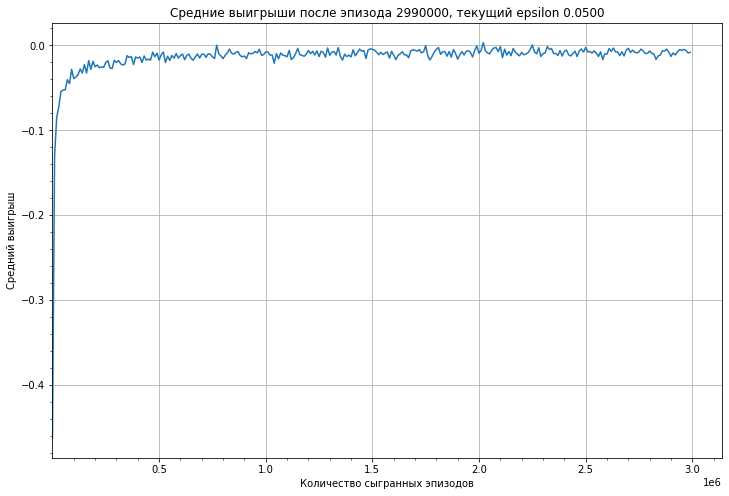

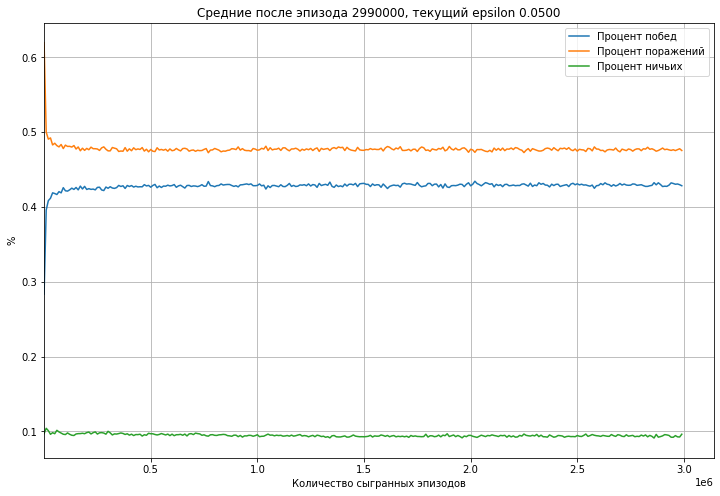

In [60]:
training_episodes = 3_000_000

experiments_mean = []
wins_mean = []
loses_mean = []
draws_mean = []

indicies = []

for i in range(training_episodes):        
    if i % 1_000_0 == 0:
        indicies.append(i)
        
        mean_rewards, mean_wins, mean_loses, mean_draws = conduct_experiments_pi(pi_policy_final, env_final, 1_000_00)
        experiments_mean.append(mean_rewards)
        wins_mean.append(mean_wins)
        loses_mean.append(mean_loses)
        draws_mean.append(mean_draws)

        plot_rewards(indicies, experiments_mean, eps=epsilon)
        plot_stats(indicies, wins_mean, loses_mean, draws_mean, eps=epsilon)
        clear_output(wait=True)
    
#     MC off-policy algorithm
    b_policy, states, actions, rewards = run_episode(pi_policy_final, env_final, [0, 1, 2], epsilon)
    
    G = 0
    W = 1
    for state, action, reward in reversed(list(zip(states, actions, rewards))): 
        G = gamma*G + reward
        reward_set.add(reward)
        C_final[state, action] += W
        Q_final[state, action] += (W / C_final[state, action])*(G-Q_final[state, action])                
        pi_policy_action = make_pi_policy_greedy_action(Q_final, pi_policy_final, state, [0, 1, 2])

        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if action != pi_policy_action:
            break

        soft_prob_b = 0
        if len(b_policy[state]) == 1:
            soft_prob_b = 1 - epsilon 
        soft_prob_b += epsilon / len(b_policy[state])        

        W *= 1 / soft_prob_b 
        
#         пробуем уменьшать exploration
        if epsilon > 0.05:
            epsilon -= eps_decay

In [66]:
print("Аж два раза у нас получилось обыграть казино (в среднем на 10000 игр)!", sorted(experiments_mean)[-2:])

Аж два раза у нас получилось обыграть казино (в среднем на 10000 игр)! [0.000365, 0.003065]


**Отчет**:
Это вторая версия блокнота. В первой версии обыграть казино (в среднем за 10к игр) так и не получилось. Потом я зашел в discord, увидел, что у кого-то все таки получилось - сел крутить гиперпараметры. Благодаря этому нашел два бага в обучении, и в итоге получилось, хоть пару раз (понятно, что выбросы), но обыграть казино)

Небольшие выводы:
1. Каждый метод из трёх чуть-чуть лучше предыдущего. Выигрыши немного растут (по 0.02 на каждом методе), но в среднем, конечно, мы все еще проигрываем казино.
2. Хорошая гамма, как мне показалось лежит в [0.4, 0.6], epsilon decay тоже, как мне показалось, неплохо "разогревает" модель.
3. Как делать реализацию split так и не догадался; наверное нормальная идея, стартовать как бы два эпизода игры, и возвращать несколько объектов руки, но как учитывать статистику по ходам я так и не придумал (или не смог обосновать корректность).

В целом, дз заняло часов 30, половина времени на лекции и доп. материалы (очень долго доходило, что вообще происходит, и почему так).

UPD: После многих часов обучения, оказалось, что double можно делать только на первом ходу. Наверное можно считать, что у нас в казино разрешено делать double в любое время :/